In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

no display found. Using non-interactive Agg backend


## 1. Import Datasets

In [2]:
test_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Translation_Test/test_table.csv')
user_data = pd.read_csv('/Users/ChunyanHao/Desktop/GitHub/DS_Take_Home/data/Translation_Test/user_table.csv')

In [3]:
test_data.head(3)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0


In [4]:
user_data.head(3)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [6]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


user_data has 454 less records than test_data. We need to merge these two datasets and check the mapping result

merge two tables and be careful to keep records which is in the test set but not in the user set

In [7]:
data = pd.merge(left = test_data, right = user_data, how = 'left', left_on = 'user_id', right_on = 'user_id')
data.head(3)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain


In [8]:
data.describe()

,user_id,conversion,test,age
count,453321.000000,453321.000000,453321.000000,452867.000000
mean,499937.514728,0.049579,0.476446,27.130740
std,288665.193436,0.217073,0.499445,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249816.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749522.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [9]:
data.isna().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

The 454 missing records, which contains missing values in important features, only take less than 0.2% percent of the population, we can delete them directly

In [10]:
data = data[data['sex'].notnull()]

understand the unique values for each variable

In [11]:
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

user_id              452867	 [315281 497851 848402 290051 548435]
date                     5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source                   3	 ['Direct' 'Ads' 'SEO']
device                   2	 ['Web' 'Mobile']
browser_language         3	 ['ES' 'Other' 'EN']
ads_channel              6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo']
browser                  7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App']
conversion               2	 [1 0]
test                     2	 [0 1]
sex                      2	 ['M' 'F']
age                     52	 [32. 21. 34. 22. 19.]
country                 17	 ['Spain' 'Mexico' 'Venezuela' 'Bolivia' 'Colombia']


## 2. Check if the test results is true

In [12]:
data[['test','conversion']].groupby(['test']).mean().reset_index()

,test,conversion
0,0,0.055156
1,1,0.043411


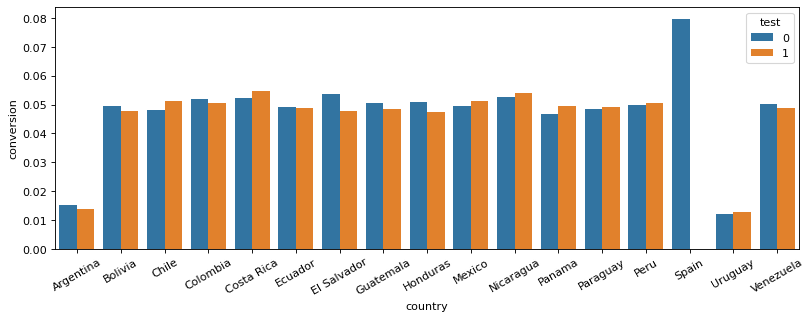

In [13]:
group_country_test = data[['test','country', 'conversion']].groupby(['test', 'country']).mean().reset_index()

plt.figure(figsize=(12, 4), dpi=80)
sns.barplot(data = group_country_test, x ='country', hue='test', y = 'conversion')

plt.xticks(rotation= 30)
plt.show()

The bar plot above displays data distribution among different countries and test/control groups. 
we can figure out that:
    1) the conversion rate of Spain is extremely high. But it doesn't have control group.
    2) the differences of conversion rates between test and control in other countries are not consistent.
    
we can remove the influence of Spain:

In [14]:
data[(data['country']!= 'Spain')][['test','conversion']].groupby(['test']).mean().reset_index()

,test,conversion
0,0,0.048292
1,1,0.043411


After removing Spain, the difference between test and control groups decreased. But still, control group (old translation) works better than test group(native translation).

In [15]:
import scipy.stats as st

In [16]:
test_set =  data[(data['test'] == 1) & (data['country']!= 'Spain')]['conversion'].values
control_set =  data[(data['test'] == 0) & (data['country']!= 'Spain')]['conversion'].values

In [17]:
st.ttest_ind(test_set, control_set, equal_var = False)

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)

In [18]:
mean_test_set = test_set.mean()
mean_control_set = control_set.mean()
print('mean_test_set:', mean_test_set,'\n', 
      'mean_control_set:', mean_control_set )

mean_test_set: 0.043411161678422794 
 mean_control_set: 0.04829179055749524


In [19]:
var_test_set = np.var(test_set)
var_control_set = np.var(control_set)
print('var_test_set:', var_test_set,'\n', 
      'var_control_set:', var_control_set)

var_test_set: 0.04152663272015262 
 var_control_set: 0.04595969352224624


## 3. Data analysis

### 3.1 analyze the conversion rate day by day

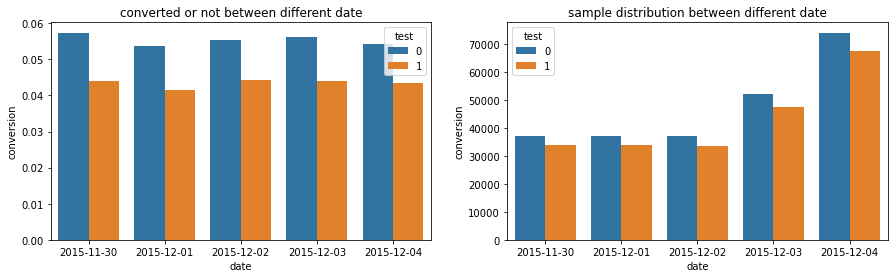

In [20]:
group_date_test_1 = test_data[['test','date', 'conversion']].groupby(['test', 'date']).mean().reset_index()
group_date_test_2 = test_data[['test','date', 'conversion']].groupby(['test', 'date']).count().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(data = group_date_test_1, x ='date', hue='test', y = 'conversion', ax = ax[0])
ax[0].set_title('converted or not between different date')

sns.barplot(data = group_date_test_2, x ='date', hue='test', y = 'conversion', ax = ax[1])
ax[1].set_title('sample distribution between different date')

plt.show()

Plot above shows that the conversion rate of test group has some fluctuation everyday but without significant change.  

The total customer in both control group and test group increased gradually after December.

It's recommended to run the AB test at least for one week to capture the weekly pattern and two weeks would be even better.

### 3.2 Analyze data distribution difference between test and control group

Another possible reason for this strange result would be that the distribution of users between test and control groups are not random. There might be other factors which influence whether the user belongs to the test group or not.
One possible way to explore this is to build a tree regression to see if there are any variables can decide the belonging of test group or control group.

In [21]:
x_columns = ['source', 'device', 'browser_language','ads_channel', 'browser', 
             'conversion', 'sex', 'age', 'country']
reg_data = data[(data['country']!= 'Spain')]
x_train = pd.get_dummies(data = reg_data[x_columns], columns = ['source', 'device', 'browser_language','ads_channel', 
             'browser', 'sex', 'country'])
y_train = reg_data['test']

In [22]:
fullClassTree = DecisionTreeClassifier(random_state=1, max_depth = 4).fit(x_train, y_train)

In [23]:
for importance, name in sorted(zip(fullClassTree.feature_importances_, x_train.columns),reverse=True):
    print (name, importance)

country_Argentina 0.8447964157225519
country_Uruguay 0.15294486786815126
age 0.000735989437985168
ads_channel_Yahoo 0.00031461983343794835
browser_Safari 0.00031121680050687033
ads_channel_Bing 0.00022401523437741148
browser_FireFox 0.00019855895774361376
conversion 0.00018848777279222665
browser_Chrome 0.00010272950987243884
browser_language_Other 8.530193799447509e-05
ads_channel_Facebook 5.9734159099510626e-05
sex_F 3.80627654871355e-05
source_SEO 0.0
source_Direct 0.0
source_Ads 0.0
sex_M 0.0
device_Web 0.0
device_Mobile 0.0
country_Venezuela 0.0
country_Peru 0.0
country_Paraguay 0.0
country_Panama 0.0
country_Nicaragua 0.0
country_Mexico 0.0
country_Honduras 0.0
country_Guatemala 0.0
country_El Salvador 0.0
country_Ecuador 0.0
country_Costa Rica 0.0
country_Colombia 0.0
country_Chile 0.0
country_Bolivia 0.0
browser_language_ES 0.0
browser_language_EN 0.0
browser_Opera 0.0
browser_Iphone_App 0.0
browser_IE 0.0
browser_Android_App 0.0
ads_channel_Other 0.0
ads_channel_Google 0.0


It seems that countries like Argentina and Uruguay affects the sameple distribution significantly.

We can generate plot and pivot table to verify our arguments.

In [24]:
group_country_1 = reg_data[['test','country', 'user_id']].groupby(['country', 'test']).count().reset_index()
group_country_2 = reg_data[['country', 'user_id']].groupby(['country']).count().reset_index()

group_country_test = pd.merge(left = group_country_1, 
                              right = group_country_2,
                             how = 'left', left_on = 'country', right_on = 'country')
group_country_test.columns = ['country','test', 'count_sub', 'count_total']
group_country_test['test_control_ratio'] = group_country_test['count_sub'] / group_country_test['count_total']
group_country_test.sort_values(by=['test_control_ratio'], ascending=False)

,country,test,count_sub,count_total,test_control_ratio
29,Uruguay,1,3719,4134,0.899613
1,Argentina,1,37377,46733,0.799799
16,Honduras,0,4361,8568,0.508987
20,Nicaragua,0,3419,6723,0.508553
10,Ecuador,0,8036,15895,0.505568
14,Guatemala,0,7622,15125,0.503934
30,Venezuela,0,16149,32054,0.503806
25,Paraguay,1,3697,7347,0.503199
12,El Salvador,0,4108,8175,0.502508
23,Panama,1,1985,3951,0.502404


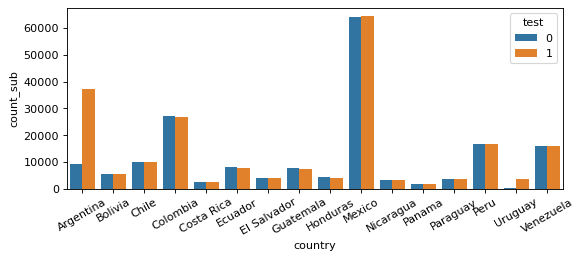

In [25]:
plt.figure(figsize=(8, 3), dpi=80)
sns.barplot(data = group_country_test, x ='country', hue='test', y = 'count_sub')
plt.xticks(rotation= 30)

plt.show()

We can then run the T-test after removing Argentina and Uruguay:

In [26]:
modified_data = reg_data[(reg_data['country'] != 'Argentina') & (reg_data['country'] != 'Uruguay')]
test_set =  modified_data[(modified_data['test'] == 1)]['conversion'].values
control_set =  modified_data[(modified_data['test'] == 0)]['conversion'].values

print('mean_test_set:', test_set.mean(),'\n', 
      'mean_control_set:', control_set.mean())

st.ttest_ind(test_set, control_set, equal_var = False)

mean_test_set: 0.050412759477438486 
 mean_control_set: 0.05014811438988265


Ttest_indResult(statistic=0.3583455794481446, pvalue=0.7200849282884506)

The modified T-test result shows that there is no significant difference in conversion rate between the native translation and old translation version of website.

### 3.3. Analyze the conversion rate between other variables

Except for contries, we also notice that variables including age, broswer and sex are significant to decide if the sample belongs to test or control group.
we can plot the related plots to do more analysis.

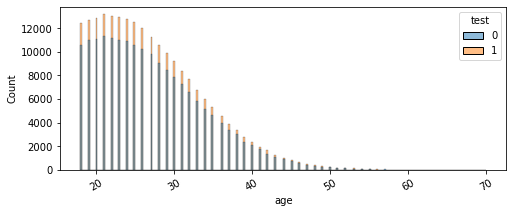

In [27]:
plt.figure(figsize=(8, 3))
sns.histplot(data = reg_data, x ='age', hue='test')
plt.xticks(rotation= 30)

plt.show()

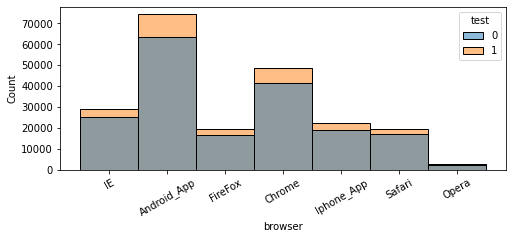

In [28]:
plt.figure(figsize=(8, 3))
sns.histplot(data = reg_data, x ='browser', hue='test')
plt.xticks(rotation= 30)

plt.show()

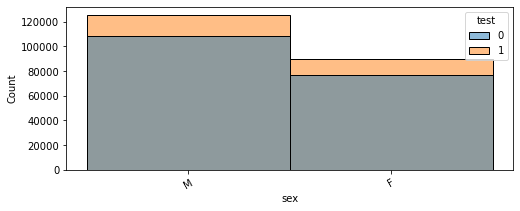

In [29]:
plt.figure(figsize=(8, 3))
sns.histplot(data = reg_data, x ='sex', hue='test')
plt.xticks(rotation= 30)

plt.show()